In [1]:
!pip cache purge
!df -h

Files removed: 41
Filesystem      Size  Used Avail Use% Mounted on
overlay          37G   24K   37G   1% /
tmpfs            64M     0   64M   0% /dev
tmpfs           7.8G     0  7.8G   0% /sys/fs/cgroup
shm             4.0G     0  4.0G   0% /dev/shm
/dev/nvme0n1p1   50G   17G   34G  33% /opt/.sagemakerinternal
/dev/nvme1n1     25G   25G  623M  98% /home/studio-lab-user
devtmpfs        7.8G     0  7.8G   0% /dev/tty
tmpfs           7.8G     0  7.8G   0% /proc/acpi
tmpfs           7.8G     0  7.8G   0% /sys/firmware


In [2]:
!pip install matplotlib torch torchvision yfinance --quiet

In [2]:
!pip install yfinance --quiet

In [87]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Step 1: Load the Google Stock Dataset
data = yf.download('GOOGL', start="2015-01-01", end="2023-01-01")
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Use 5 key features
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,26.629999,26.790001,26.393999,26.477501,26480000
2015-01-05,26.357500,26.399500,25.887501,25.973000,41182000
2015-01-06,26.025000,26.060499,25.277500,25.332001,54456000
2015-01-07,25.547501,25.574499,25.182501,25.257500,46918000
2015-01-08,25.075500,25.375000,24.750999,25.345501,73054000
...,...,...,...,...,...
2022-12-23,87.110001,89.550003,87.070000,89.230003,23003000
2022-12-27,88.800003,88.940002,87.010002,87.389999,20097300
2022-12-28,86.980003,88.040001,85.940002,86.019997,19523200


In [6]:
# Step 2: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale the data between 0 and 1
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.0132079 , 0.01403593, 0.01486488, 0.01299751, 0.0692677 ],
       [0.01105014, 0.01094976, 0.01079182, 0.00896103, 0.12858584],
       [0.00841727, 0.0082706 , 0.00588645, 0.00383245, 0.18214242],
       ...,
       [0.4910839 , 0.49810131, 0.49370948, 0.48939274, 0.04119911],
       [0.48823327, 0.50450281, 0.49909733, 0.50883499, 0.05657252],
       [0.4910839 , 0.50015614, 0.49877566, 0.50707484, 0.05920637]])

In [89]:
# Create sequences of stock data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 3])  # Predict 'Close' price (3rd column)
    return np.array(X), np.array(y)

In [80]:
SEQ_LENGTH = 50000  # Use 12000 days of data to predict 
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [9]:
# Split into training and testing datasets
split_idx = int(0.8 * len(X))  # 80% training, 20% testing
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [10]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [90]:
# Step 3: Build the LSTM Model with PyTorch
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 50)  # First dense layer
        self.relu = nn.ReLU()  
        self.fc2 = nn.Linear(50, output_size)  # Output layer
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Fully connected layers
        out = self.fc1(out[:, -1, :])  # Get the last time step output
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [75]:
# Model parameters
input_size = X_train.shape[2]  # Number of features (Open, High, Low, Close, Volume)
hidden_size = 128*5  # Number of hidden units in LSTM
num_layers = 5  # Number of LSTM layers
output_size = 1  # We are predicting the 'Close' price

In [22]:
# Initialize the model, loss function, and optimizer
model = StockPriceLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [81]:
# Step 4: Train the Model
num_epochs = 20
batch_size = 64

In [15]:
# DataLoader to load data in batches
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [82]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/20], Loss: 0.0003
Epoch [2/20], Loss: 0.0008
Epoch [3/20], Loss: 0.0002
Epoch [4/20], Loss: 0.0004
Epoch [5/20], Loss: 0.0002
Epoch [6/20], Loss: 0.0004
Epoch [7/20], Loss: 0.0005
Epoch [8/20], Loss: 0.0002
Epoch [9/20], Loss: 0.0004
Epoch [10/20], Loss: 0.0004
Epoch [11/20], Loss: 0.0003
Epoch [12/20], Loss: 0.0002
Epoch [13/20], Loss: 0.0007
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0003
Epoch [16/20], Loss: 0.0002
Epoch [17/20], Loss: 0.0005
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0002
Epoch [20/20], Loss: 0.0002


In [86]:
# Saving the model's state dict 
pathdir = os.path.expanduser('~/LSTM/model')
os.makedirs(pathdir, exist_ok=True)

# Save the model's state dict
torch.save(model.state_dict(), f'{pathdir}/stock_lstm_model.pth')

In [83]:
# Step 5: Evaluate the Model
model.eval()  
with torch.no_grad():
    predictions = model(X_test).cpu().numpy()  # Predict stock prices
    true_values = y_test.cpu().numpy()

In [84]:
# Inverse scaling to get actual prices
predictions_reshaped = predictions.reshape(-1, 1)
true_values_reshaped = true_values.reshape(-1, 1)

y_pred_inverse = scaler.inverse_transform(np.concatenate([np.zeros((predictions_reshaped.shape[0], 3)), predictions_reshaped, np.zeros((predictions_reshaped.shape[0], 1))], axis=1))[:, 3]
y_test_inverse = scaler.inverse_transform(np.concatenate([np.zeros((true_values_reshaped.shape[0], 3)), true_values_reshaped, np.zeros((true_values_reshaped.shape[0], 1))], axis=1))[:, 3]


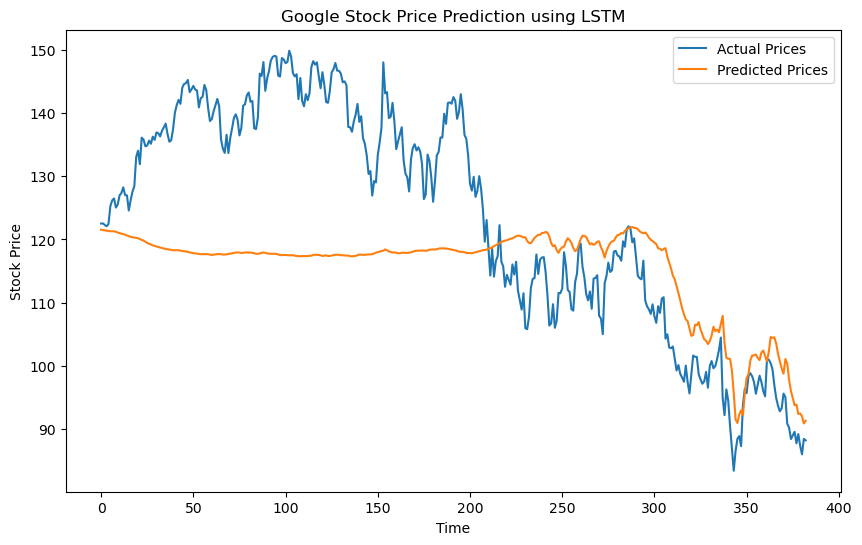

In [85]:
# Step 6: Plot the Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Google Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
# 50000, 128*5  , 5, 20 epochs

In [91]:
# Step 7: Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
print(f'Root Mean Squared Error: {rmse:.4f}')

Root Mean Squared Error: 16.3401
